Vamos a crear unos datos MUYYY sencillitos, y vamos a entrenar el modelo en RECONSTRUIRLOS solo. No vamos a pretender que haga nada más.   
Luego le meteremos lo de al AssDis.

In [1]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer

from torch import optim

from torch.utils.data import DataLoader,Dataset

# Los datos sinteticos

Voy a hacer un generador que nos de una secuencia regular, con puntos de anomalia


In [2]:
def sinne(lenght=100,amp=1,sf=0.1,f=2,phase=0):
    x = torch.arange(0,lenght*sf, sf)
    return amp*torch.sin(x*sf*2*torch.pi/f+phase)


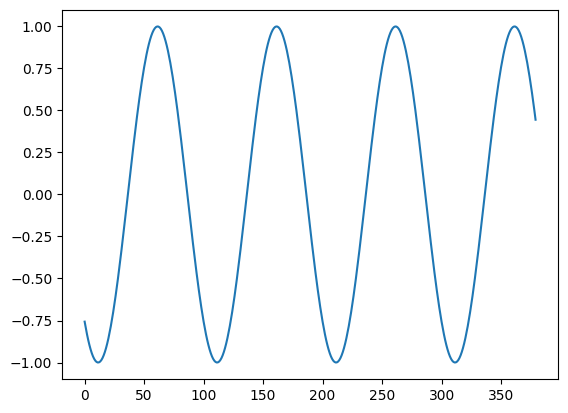

In [3]:
y=sinne(380,sf=0.1,f=1,phase=4)
plt.plot(y)

Y ahora el generador de datos. Le decimos que nos devuelva un batch de datos y nos lo da.

In [4]:
class Data(Dataset):
    #esta es la clase de los datos que seran secuencias de senos de freq aleatoria 
    def __init__(self,lenght,num_samples,amp_random=True,freq_random=True,phase_random=True,sf=0.1):
        super().__init__()
        self.amp_random=amp_random
        self.freq_random=freq_random
        self.phase_random=phase_random
        self.num_samples=num_samples
        self.sf=0.1
        self.lenght=lenght

    def __len__(self):

        return self.num_samples


    def __getitem__(self, index):
        amp=float(np.random.randint(1,300,1)*0.01)
        phase=np.random.randint(0,100,1)*0.02
        f=np.random.randint(1,200,1)*0.01
        y=sinne(lenght=self.lenght,amp=amp,sf=0.1,f=f,phase=phase)
        y=y.unsqueeze(-1)
        return y


In [5]:
win_size=600
data=Data(win_size,4000)

dataloader=DataLoader(data,batch_size=32,shuffle=True)

In [32]:
a=next(iter(dataloader))

In [33]:
a.shape

torch.Size([32, 600, 1])

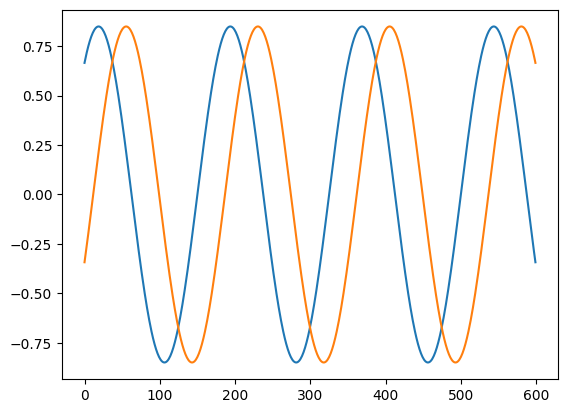

In [36]:
plt.plot(a[1])
plt.plot(a.flip(1)[1])

No es todo lo personalizable que querria, pero bien, ahora creamos la red. 

In [6]:
modelo=AnomalyTransformer.AnomalyTransformer(win_size, 1, 1, d_model=32, n_heads=4, e_layers=1, d_ff=32,
                          dropout=0.4, activation='gelu', output_attention=True)

In [7]:
print(modelo)

AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.4, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=4, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bias=Tru

In [8]:
modelo

AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.4, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=4, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bias=Tru

In [9]:
def count_parameters(model):
    total=sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total}")
    return total
count_parameters(modelo)

Total trainable parameters: 6853


6853

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(modelo.parameters(), lr=0.001)
modelo.cuda()
# Entrenamiento
num_epochs = 50
for epoch in range(num_epochs):
    for i, (inputs) in enumerate(dataloader):
        # Forward
        inputs=inputs.float().to("cuda:0")
        outputs, series, prior, _ = modelo(inputs)
        loss = criterion(outputs, inputs)

        # Backward y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printear resultados
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

print("Entrenamiento finalizado")

Epoch [1/50], Step [1/125], Loss: 3.2365
Epoch [1/50], Step [2/125], Loss: 2.1655
Epoch [1/50], Step [3/125], Loss: 1.7248
Epoch [1/50], Step [4/125], Loss: 2.1572
Epoch [1/50], Step [5/125], Loss: 1.8947
Epoch [1/50], Step [6/125], Loss: 1.5910
Epoch [1/50], Step [7/125], Loss: 1.4460
Epoch [1/50], Step [8/125], Loss: 1.1320
Epoch [1/50], Step [9/125], Loss: 0.9927
Epoch [1/50], Step [10/125], Loss: 1.0217
Epoch [1/50], Step [11/125], Loss: 0.9188
Epoch [1/50], Step [12/125], Loss: 0.9205
Epoch [1/50], Step [13/125], Loss: 0.9759
Epoch [1/50], Step [14/125], Loss: 0.6115
Epoch [1/50], Step [15/125], Loss: 0.4965
Epoch [1/50], Step [16/125], Loss: 0.5357
Epoch [1/50], Step [17/125], Loss: 0.5358
Epoch [1/50], Step [18/125], Loss: 0.5302
Epoch [1/50], Step [19/125], Loss: 0.5426
Epoch [1/50], Step [20/125], Loss: 0.6571
Epoch [1/50], Step [21/125], Loss: 0.4393
Epoch [1/50], Step [22/125], Loss: 0.4221
Epoch [1/50], Step [23/125], Loss: 0.4231
Epoch [1/50], Step [24/125], Loss: 0.5086
E

In [11]:
modelo

AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.4, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=4, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bias=Tru

In [12]:
a=next(iter(dataloader))
a=a.float().to("cuda:0")
y=modelo(a)


In [72]:
torch.cuda.empty_cache()

In [21]:
z=y[0].squeeze().cpu().detach().numpy()
z1=y[1][0].squeeze().cpu().detach().numpy()
z2=y[2][0].squeeze().cpu().detach().numpy()
b=a.squeeze().cpu().detach().numpy()

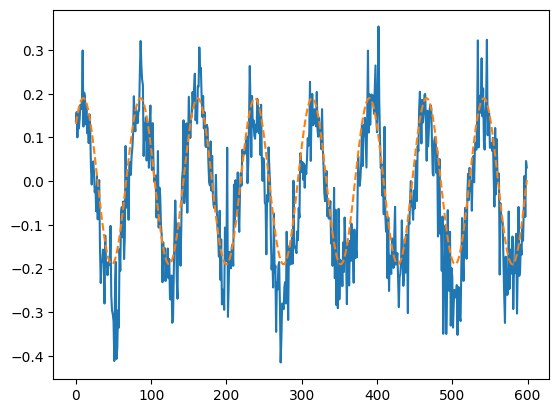

In [24]:
plt.plot(z[18])
plt.plot(b[18],"--")

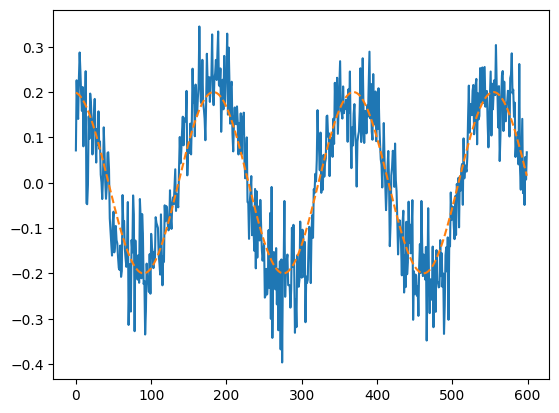

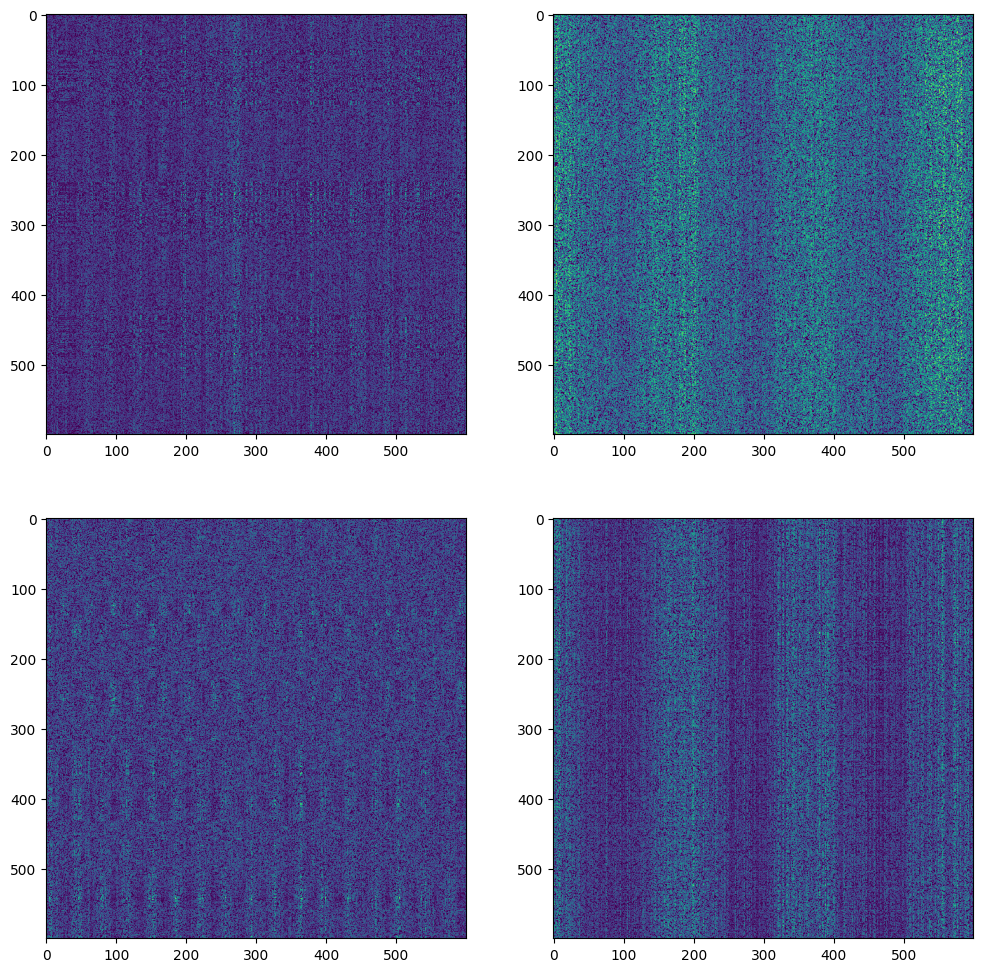

In [31]:
n=3

plt.plot(z[n])
plt.plot(b[n],"--")
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(z1[n,i])